# Preprocessing

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.feature_selection import mutual_info_regression
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from src.utils import check_shape, highlight_top, missing_values_table, save_fig, make_mi_scores, plot_mi_scores
from src.preprocessing import clean_property_type, clean_tenure, fill_missing_values, update_data, drop_columns, create_features

In [3]:
pd.set_option('display.max_columns', None)

In [4]:
data_dir = Path("../raw_data/")
img_dir = Path("./images/")

In [5]:
df_train = pd.read_csv("../clean_data/df_train_eda.csv", index_col=0)
df_train = df_train.drop(["listing_id", "title", "address", "property_name", "property_details_url", "elevation"], axis=1)
df_test = pd.read_csv(Path(data_dir, "test.csv"))

In [6]:
df_train.head()

,property_type,tenure,built_year,num_beds,num_baths,size_sqft,total_num_units,lat,lng,subzone,planning_area,price
0,hdb,99-year leasehold,1988,3.0,2.0,1115,116,1.414399,103.837196,yishun south,yishun,514500.0
1,hdb,99-year leasehold,1992,4.0,2.0,1575,375,1.372597,103.875625,serangoon north,serangoon,995400.0
2,condo,freehold,2022,4.0,6.0,3070,56,1.298773,103.895798,mountbatten,marine parade,8485000.0
3,condo,freehold,2023,3.0,2.0,958,638,1.312364,103.803271,farrer court,bukit timah,2626000.0
4,condo,99-year leasehold,2026,2.0,1.0,732,351,1.273959,103.843635,anson,downtown core,1764000.0


## Initial Mutual Information

In [7]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
df_train_num = df_train.select_dtypes(include=numerics)

In [8]:
X = df_train_num.drop("price", axis=1)
y = df_train_num["price"]

Saving figure mi_score_1


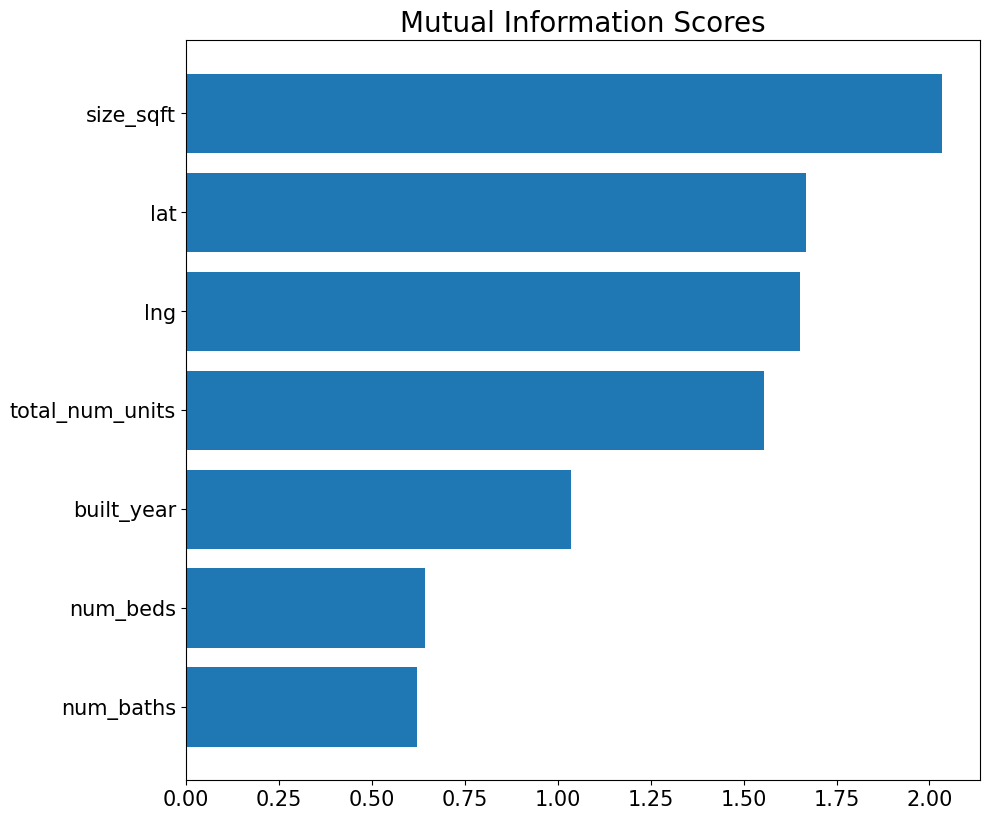

In [9]:
mi_scores = make_mi_scores(X, y)
plot_mi_scores(mi_scores, "mi_score_1", img_dir)

## Feature Engineering

- As shown in above EDA, since there are many categories in ``tenure`` with low count, we can group them together.
- We can compute the number of active years by subtracting ``built_year`` from current year
- We can target encode ``planning_area`` by replacing the values with the mean price 
- We perform one hot encoding on ``tenure`` and ``property_type``
- In our test set, we have one planning area "Boon Lay" that is not present in our training set. As a result, we wont be able to target encode the "Boon Lay". We know that "Boon Lay" is near "Jurong West" so we will impute that value instead

In [10]:
df_train_preproc = create_features(df_train)
#df_train_preproc = df_train_preproc.drop(["planning_area"], axis=1)
df_train_preproc.to_csv("../clean_data/train_preproc.csv")

In [11]:
df_train_preproc.head()

,property_type,built_year,num_beds,num_baths,size_sqft,total_num_units,lat,lng,subzone,planning_area,price,active_years,planning_area_density,remaining_lease,mean_subzone_price,mean_subzone_sqft,mean_property_sqft,mean_planning_sqft,planning_area_mean,total_rooms,size_per_room,mean_property_type,distance,num_shopping_malls,tenure_99-year leasehold,tenure_freehold
0,hdb,1988,3.0,2.0,1115,116,1.414399,103.837196,yishun south,yishun,514500.0,34,15290.636281,65,6.719120e+05,1139.543478,1079.757868,1231.474343,1.143726e+06,5.0,223.0,6.620452e+05,0.573567,2.0,1,0
1,hdb,1992,4.0,2.0,1575,375,1.372597,103.875625,serangoon north,serangoon,995400.0,30,12981.843721,69,1.623506e+06,1871.666667,1079.757868,2514.468039,3.670975e+06,6.0,262.5,6.620452e+05,1.728895,3.0,1,0
2,condo,2022,4.0,6.0,3070,56,1.298773,103.895798,mountbatten,marine parade,8485000.0,0,7535.378473,999,4.926939e+06,2401.925856,1154.798804,2011.903265,4.159877e+06,10.0,307.0,2.919816e+06,1.315256,5.0,0,1
3,condo,2023,3.0,2.0,958,638,1.312364,103.803271,farrer court,bukit timah,2626000.0,-1,5513.897301,1000,2.750650e+06,974.178248,1154.798804,2468.346271,5.576084e+06,5.0,191.6,2.919816e+06,0.723885,4.0,0,1
4,condo,2026,2.0,1.0,732,351,1.273959,103.843635,anson,downtown core,1764000.0,-4,920.930181,103,3.341467e+06,1095.525926,1154.798804,1590.161473,4.853464e+06,3.0,244.0,2.919816e+06,0.370022,16.0,1,0


In [12]:
missing_values_table(df_train_preproc)

Your selected dataframe has 26 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


In [13]:
X = df_train_preproc.drop("price", axis=1)
y = df_train_preproc["price"]

Saving figure mi_score_2


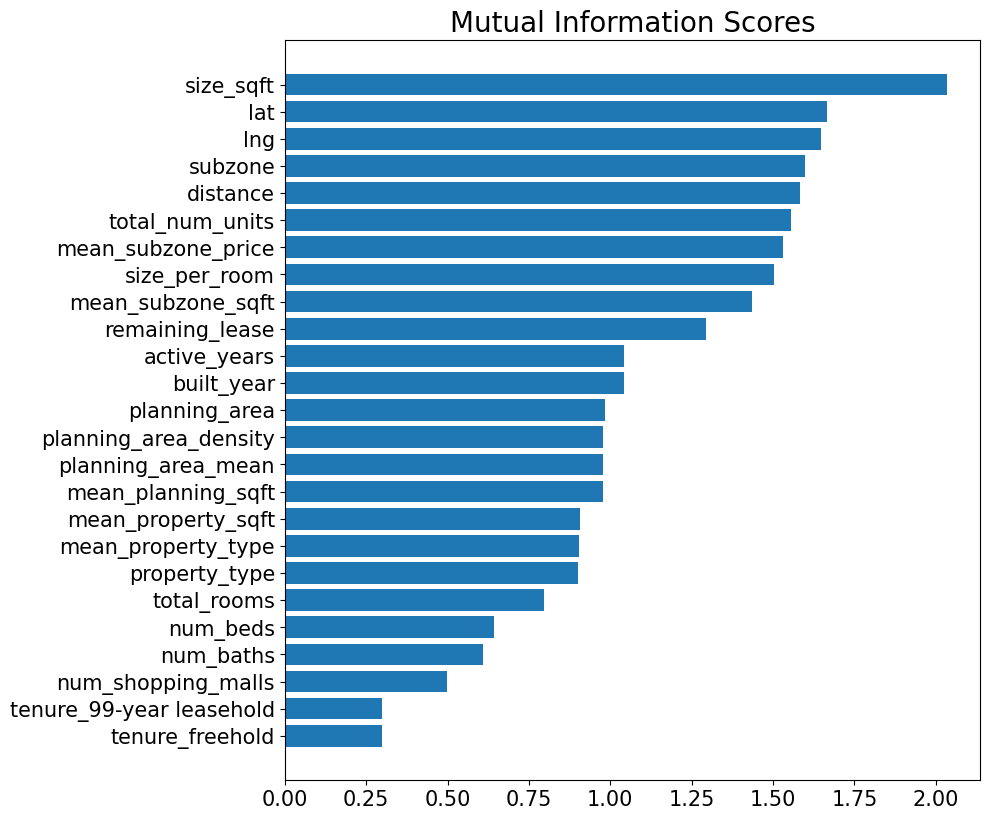

In [14]:
mi_scores = make_mi_scores(X, y)
plot_mi_scores(mi_scores, "mi_score_2", img_dir)

- Since size_sqft is highly informative, we will create more features with it.

In [15]:
df_test_preproc = clean_property_type(df_test)
df_test_preproc = clean_tenure(df_test_preproc)
df_test_preproc = fill_missing_values(df_test_preproc)
df_test_preproc = update_data(df_test_preproc)
df_test_preproc = create_features(df_test_preproc)
df_test_preproc = drop_columns(df_test_preproc)

In our test set, one particular planning area "Boon Lay" was not present in our training set. As a
result, we were not able to target encode it. Since we know "Boon Lay" is near "Jurong West", we imputed
that value instead

In [16]:
# since all values will be the same, doesn't matter if we take max
jurong_west_price_mean = df_test_preproc[df_test_preproc["planning_area"] == "jurong west"]["planning_area_mean"].max()
df_test_preproc["planning_area_mean"] = np.where(df_test_preproc["planning_area"]=="boon lay",  jurong_west_price_mean, df_test_preproc["planning_area_mean"])
df_test_preproc.to_csv("../clean_data/test_preproc.csv")

In [17]:
missing_values_table(df_test_preproc)

Your selected dataframe has 25 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


In [18]:
df_test_preproc.head()

,property_type,built_year,num_beds,num_baths,size_sqft,total_num_units,lat,lng,subzone,planning_area,active_years,planning_area_density,remaining_lease,mean_subzone_price,mean_subzone_sqft,mean_property_sqft,mean_planning_sqft,planning_area_mean,total_rooms,size_per_room,mean_property_type,distance,num_shopping_malls,tenure_99-year leasehold,tenure_freehold
0,condo,2022.0,1.0,1.0,463,250.000000,1.344334,103.878690,upper paya lebar,serangoon,0.0,12981.843721,999.0,2.098455e+06,990.208333,1154.798804,2514.468039,3.670975e+06,2.0,231.500000,2.919816e+06,0.261673,3.0,0,1
1,condo,2017.0,3.0,3.0,1033,463.000000,1.380281,103.943878,pasir ris west,pasir ris,5.0,12440.302188,94.0,2.132070e+06,2142.916667,1154.798804,2533.923372,2.735870e+06,6.0,172.166667,2.919816e+06,1.001264,4.0,1,0
2,condo,2007.0,1.0,1.0,570,646.000000,1.294668,103.850074,bras basah,museum,15.0,658.651377,84.0,1.663594e+06,859.187500,1154.798804,837.848249,2.212662e+06,2.0,285.000000,2.919816e+06,0.251350,2.0,1,0
3,hdb,2017.0,3.0,2.0,1216,968.000000,1.373120,103.746094,keat hong,choa chu kang,5.0,31918.595787,94.0,6.668446e+05,1169.326087,1079.757868,1276.588235,7.643136e+05,5.0,243.200000,6.620452e+05,0.767490,8.0,1,0
4,hdb,1973.0,3.0,2.0,936,370.844848,1.341468,103.849047,braddell,toa payoh,49.0,16373.600151,50.0,9.198407e+05,1139.444444,1079.757868,1012.970588,1.506176e+06,5.0,187.200000,6.620452e+05,0.767490,2.0,1,0
